In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import glob

In [2]:
ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [17]:
#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss) OR all gce (gce_clip)

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_sapelodissolve.shp'

gce = 'F:/Wetlands shapefiles/GCE domain/sapelo_area.shp'

flux_ga = geemap.shp_to_ee(gce)

## DEM
elevation = ee.Image('USGS/3DEP/10m').clip(flux_ga) ##This is 1/3 arc second, or 10 m.

In [18]:
bb = flux_ga.geometry()

In [19]:
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

In [20]:
# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)


#Function to add elevation

def add_elevation(image):
    elevation_band = elevation.rename('elevation')
    return image.addBands(elevation_band)

In [21]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [22]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation)


In [23]:
#Filtering by month

ultra_col = l8_col.merge(l5_col).merge(l7_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')) \
#     .filter(ee.Filter.calendarRange(12, 12, 'month')) \
#     .filterBounds(flux_ga)

ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))  \
    .filter(ee.Filter.calendarRange(1, 12, 'month')) 

In [24]:
#Adding tide
import glob
import pandas as pd

# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

path = r'C:/Users/arj26323/Documents/Data/flats/Tide data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])


time_mask = (df2['Time (GMT)'].dt.hour == 16)
df_time = df2[time_mask]

df_time

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY
16,1985/01/02,2024-05-07 16:00:00,0.340,-,0.479,1985-01-02
40,1985/01/03,2024-05-07 16:00:00,0.275,-,0.406,1985-01-03
64,1985/01/04,2024-05-07 16:00:00,0.374,-,0.458,1985-01-04
88,1985/01/05,2024-05-07 16:00:00,0.620,-,0.543,1985-01-05
112,1985/01/06,2024-05-07 16:00:00,0.967,-,1.162,1985-01-06
...,...,...,...,...,...,...
350536,1984/12/28,2024-05-07 16:00:00,1.759,-,1.83,1984-12-28
350560,1984/12/29,2024-05-07 16:00:00,1.466,-,1.449,1984-12-29
350584,1984/12/30,2024-05-07 16:00:00,1.148,-,1.104,1984-12-30
350608,1984/12/31,2024-05-07 16:00:00,0.835,-,0.927,1984-12-31


In [25]:
# df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')
# x = df_u['Verified (m)']
# x.quantile(0.67)

#LOW: < 0.8
#Mid: 0.8-1.8
#High: > 1.8

In [26]:
# Get the image IDs and acquisition dates separately
image_ids = ultra_col.aggregate_array('system:id').getInfo()
acquisition_dates = ultra_col.aggregate_array('system:time_start').getInfo()

# Create the DataFrame
dfx = pd.DataFrame({'Image': image_ids, 'acquisition_date': acquisition_dates})

dfx['Date'] = pd.to_datetime(dfx['acquisition_date'], unit='ms')
dfx['DOY'] = dfx['Date'].dt.strftime('%Y-%m-%d')
dfx['DOY'] = pd.to_datetime(dfx['DOY'])

df_u = pd.merge(dfx, df_time, on = 'DOY')

df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')

# Display the DataFrame
# print(dfx)
# print(df_u)

df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')

df_low = df_u[df_u['Verified (m)'] <= 0.8]
df_mid = df_u[df_u['Verified (m)'].between(0.8, 1.8)]
df_high = df_u[df_u['Verified (m)'] >= 1.8]

# print(df_high)

In [31]:
#Slope of flats, by pixel

# Create a list of image names
low_names = df_low['Image'].tolist()
mid_names = df_mid['Image'].tolist()
high_names = df_high['Image'].tolist()

# Initialize separate lists
LT05_list = []
LE07_list = []
LC09_list = []
LC08_list = []
other_list = []

# Iterate through the satellite names and separate them based on keys
names = low_names

for name in names:
    if 'LT05' in name:
        LT05_list.append(name)
    elif 'LE07' in name:
        LE07_list.append(name)
    elif 'LC09' in name:
        LC09_list.append(name)
    elif 'LC08' in name:
        LC08_list.append(name)
    else:
        other_list.append(name)

col5 = ee.ImageCollection(LT05_list).map(maskL5sr).map(addFLATSL5).map(add_elevation)
col7 = ee.ImageCollection(LE07_list).map(maskL5sr).map(addFLATSL7).map(add_elevation)
col8 = ee.ImageCollection(LC08_list).map(maskL5sr).map(addFLATSL8).map(add_elevation)
col9 = ee.ImageCollection(LC09_list).map(maskL5sr).map(addFLATSL9).map(add_elevation)

col = col5.merge(col7).merge(col8).merge(col9)

# col = col.filter(ee.Filter.calendarRange(1984, 1994,'year')).filterBounds(flux_ga)

study_area = flux_ga.geometry()

col = col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50)).filterBounds(study_area)

# Function to calculate linear regression for each pixel
def add_time(image):
    # Add a band representing time in years
    time = image.metadata('system:time_start').divide(31536000000)  # milliseconds to years
    return image.addBands(time.rename('time'))

colx = col.map(add_time)

# Perform linear regression for each pixel
linearFit = colx.select(['time', 'flats']).reduce(
        reducer=ee.Reducer.linearFit()
    )

In [32]:
#Directory
out_dir = os.path.join("F:/Flats imagery/Tide stage composites/GCE")
##Draw geometry for exported images! It will look better

image = linearFit
filename = os.path.join(out_dir, 'low_slope.tif')

image = image.clip(bb).unmask()

# geemap.ee_export_image(
#     image.select('scale'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )

Generating URL ...
Please wait ...
Data downloaded to F:\Flats imagery\Tide stage composites\GCE


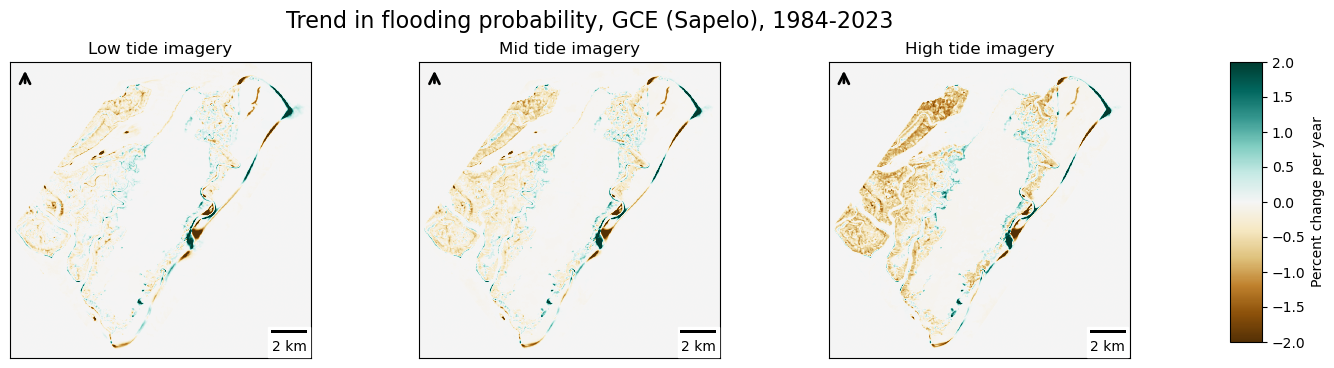

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

h_x = "F:/Flats imagery/Tide stage composites/GCE/high_slope.scale.tif"
m_x = "F:/Flats imagery/Tide stage composites/GCE/mid_slope.scale.tif"
l_x = "F:/Flats imagery/Tide stage composites/GCE/low_slope.scale.tif"

slope_paths = [l_x, m_x, h_x]

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, data_min, data_max):
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 1
        data = data ** gamma 

        # Normalize the data based on the overall min and max values
        data_normalized = (data) / (1)*100
        
        cmap = 'BrBG'
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=-2, vmax=2)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.05, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.05, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im

# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # Adjusted figsize

ims = []
titles = ['Low tide imagery', 'Mid tide imagery', 'High tide imagery']
data_min = float('inf')
data_max = float('-inf')

for i, ax in enumerate(axs.flat):
    with rasterio.open(slope_paths[i]) as src:
        data = src.read(1)
        data_min = min(data_min, np.min(data))
        data_max = max(data_max, np.max(data))

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(slope_paths[i], ax, titles[i], data_min, data_max)
    ims.append(im)

plt.suptitle('Trend in flooding probability, GCE (Sapelo), 1984-2023', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ims[-1], cax=cbar_ax, label='Percent change per year')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('allsap_trend.png',bbox_inches='tight', dpi = 300)

plt.show()
